In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale
import time

In [2]:
device = torch.device('cuda:0')
dtype = torch.float32
torch.backends.cudnn.benchmark = True

In [3]:
def read_all_image_folders(directories):
    images_150, images_300 = [], []
    for ix in directories:
        directory = f"../data/CAT_0{ix}/x1"
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                image = imageio.imread(f'{directory}/{filename}')
                images_300.append(scale_image(image, 1))        
                images_150.append(scale_image(image, 0.5))
    return images_150, images_300

In [4]:
def scale_image(image, scale):
    image = rescale(image=image, scale=scale, multichannel=True, anti_aliasing=True) 
    return image

In [5]:
learning_rate = 0.001
batch_size = 32
epochs = 51 #True runtime: epochs * train() call

In [6]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 11, stride = 1, padding = 5),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size = 11, stride = 2, padding = 5, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size = 5, stride = 1, padding = 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.generator(x)
        return x

In [7]:
model = generator().cuda()

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [9]:
# Train
def train(x, y, epochs, batch_size):
    
    loss_hist = []
    psnr_hist = []
    mse_hist = []
    
    start = time.time()

    for t in range(epochs):
        for batch in range(0, int(x.shape[0]/batch_size)):
            
            batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
            batch_y = y[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        
            outputs = model.forward(batch_x)

            loss = criterion(outputs, batch_y)
            mse = F.mse_loss(outputs, batch_y)
            psnr = 10 * math.log10(1 / mse)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % 5 == 0:
            loss_hist.append(loss.item())
            psnr_hist.append(psnr)
            mse_hist.append(mse)
            print(t, f"PSNR: {psnr}, BCE: {loss.item()}, MSE: {mse}, Time (m): {(time.time() - start) / 60}")
            
            if psnr > 30:
                torch.save(model.cpu(), f'../data/models/x2_{psnr}.pt')
            
    print('----------')
    print(f'Train Time (m): {(time.time() - start) / 60}')
    
    plt.plot(loss_hist)
    plt.show()
    
    plt.plot(psnr_hist)
    plt.show()
    
    return psnr

In [10]:
directories = [0, 1, 2]

data_150, data_300 = read_all_image_folders(directories)

x = torch.tensor(data_150, device = device, dtype = dtype)
y = torch.tensor(data_300, device = device, dtype = dtype)

/home/alex/.conda/envs/super-scaler/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0 PSNR: 23.235506288979195, BCE: 0.537420392036438, MSE: 0.004747329279780388, Time (m): 0.5714014848073323
5 PSNR: 24.684818292753313, BCE: 0.5336917042732239, MSE: 0.0034003073815256357, Time (m): 3.356267786026001
10 PSNR: 26.5569350028178, BCE: 0.5303505659103394, MSE: 0.0022095635067671537, Time (m): 6.092880670229594
15 PSNR: 26.686966113503033, BCE: 0.530346691608429, MSE: 0.0021443881560117006, Time (m): 8.936483891805013
20 PSNR: 27.352191540645695, BCE: 0.5293280482292175, MSE: 0.0018398433458060026, Time (m): 11.752129479249318
25 PSNR: 28.484697773453682, BCE: 0.5280114412307739, MSE: 0.0014175233663991094, Time (m): 14.533090058962504
30 PSNR: 29.10572364233234, BCE: 0.5272850394248962, MSE: 0.0012286484707146883, Time (m): 17.452994692325593
35 PSNR: 29.193827228651323, BCE: 0.5272837281227112, MSE: 0.0012039744760841131, Time (m): 20.374285729726157
40 PSNR: 29.167290225467664, BCE: 0.5272591710090637, MSE: 0.001211353694088757, Time (m): 23.292477158705392
45 PSNR: 29.0

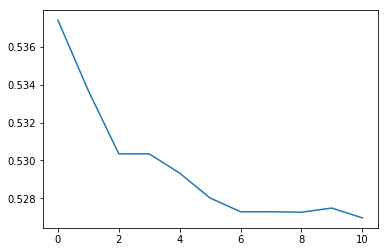

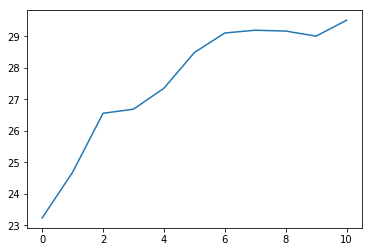

In [11]:
psnr = train(x, y, epochs, batch_size)

In [12]:
torch.cuda.memory_cached()

8149401600

In [13]:
del x, y
torch.cuda.empty_cache()

In [14]:
torch.cuda.memory_cached()

2097152

In [15]:
directories = [3, 4, 5, 6]

data_150, data_300 = read_all_image_folders(directories)

x = torch.tensor(data_150, device = device, dtype = dtype)
y = torch.tensor(data_300, device = device, dtype = dtype)

0 PSNR: 29.08458216295246, BCE: 0.5130909085273743, MSE: 0.001234644092619419, Time (m): 0.5387306888898213
5 PSNR: 28.778206464936495, BCE: 0.5134400725364685, MSE: 0.001324888551607728, Time (m): 3.22862841685613
10 PSNR: 28.591086360460665, BCE: 0.514048159122467, MSE: 0.001383220311254263, Time (m): 5.9030908147494
15 PSNR: 30.057894374278522, BCE: 0.5124315619468689, MSE: 0.0009867578046396375, Time (m): 8.540964877605438
20 PSNR: 30.350906553114122, BCE: 0.5122787356376648, MSE: 0.0009223788511008024, Time (m): 11.171316035588582
25 PSNR: 29.5578998045928, BCE: 0.512750506401062, MSE: 0.0011071590706706047, Time (m): 13.804237767060597
30 PSNR: 28.059423793585644, BCE: 0.5143129825592041, MSE: 0.0015633549774065614, Time (m): 16.459753795464835
35 PSNR: 29.79702139436891, BCE: 0.5126115083694458, MSE: 0.0010478469775989652, Time (m): 19.116135295232137
40 PSNR: 30.052926037200773, BCE: 0.5122328400611877, MSE: 0.0009878872660920024, Time (m): 21.74990131855011
45 PSNR: 28.8470366

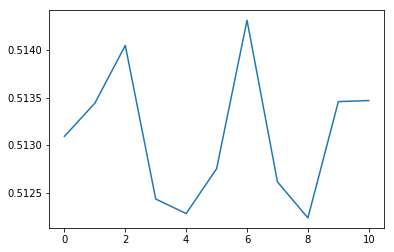

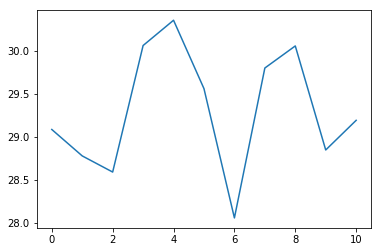

In [16]:
psnr = train(x, y, epochs, batch_size)

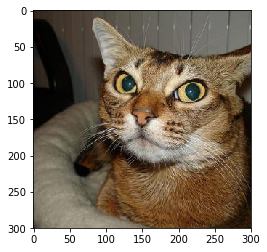

In [17]:
image = imageio.imread(f'../data/CAT_00/x1/00000001_020.jpg')
plt.imshow(image)
plt.show()

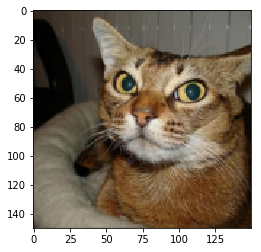

In [18]:
image_down = rescale(image=image, scale=0.5, multichannel=True, anti_aliasing=True)
plt.imshow(image_down)
plt.show()

In [19]:
image_up = model.forward(torch.tensor(image_down.reshape(1, 150, 150, 3), dtype = dtype, device = device).transpose(1, 3))

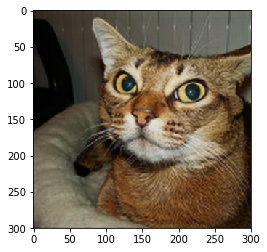

In [20]:
plt.imshow(image_up.transpose(1,3).cpu().detach().numpy().reshape(300, 300, 3))
plt.show()

In [21]:
torch.save(model.cpu(), f'../data/models/x2_F_{psnr}.pt')

/home/alex/.local/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
